# Attention seq2seq - Pytorch

Dataset: http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b <br>
The goal of this notebook is to implement a seq2seq attention model and a regular seq2seq is implemented alongside to gain a more complete picture. 

## Motivating Attention

The dataset used in this notebook contains mapping of words in English and their pronounciations as a set of phoneme word pairs like so <br>
<small><p style="margin-left: 40px">S-AE1-N-AH0-T-IY0   sanity</p></small>
The task is to use a seq2seq model to learn this mapping so that given a set of phonemes, the model outputs the correct word. It can be seen as emulating spelling bee. Given below is an image of the results obtained from a regular seq2seq model
<img src="seq2seq.png">
The words inside the red square shows a common problem with seq2seq- If only the context vector, i.e., the last hidden state in the encoder network is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence, extending upto the last timestep of the decoder. 

Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every time step of the decoder's own outputs.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import time, math, random
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

Path = 'data/'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Preprocessing

In [3]:
#Get each word that begins with A-Z from each line into a list 
lines = [l.strip().split("  ") for l in open(Path+'cmudict-0.7b', encoding='latin1') 
         if re.match('^[A-Z]', l)]
#Split words and phonemes
lines = [(w, ps.split()) for w, ps in lines]
lines[0]

('A', ['AH0'])

In [4]:
#Get a list of all the unique phonemes from lines and adding _ to position 0 because it corresponds to padding
#when tokenised
phonemes = ["_"]+sorted(set(p for w, ps in lines for p in ps))
len(phonemes)

70

In [5]:
#Map phonemes to indices and letters to indices.
p2i = dict((v, k) for k, v in enumerate(phonemes))
letters = "_abcdefghijklmnopqrstuvwxyz*"
l2i = dict((v, k) for k, v in enumerate(letters))

In [6]:
#Start of sentence token
SOS_token = 0

maxlen = 15
#Map words to corresponding list of phoneme indices. Constraint
pronounce_dict = {w.lower(): [p2i[p] for p in ps] for w, ps in lines
                    if (5<=len(w)<=maxlen) and re.match("^[A-Z]+$", w)}
len(pronounce_dict)

In [8]:
maxlen_p = max([len(v) for k,v in pronounce_dict.items()]); maxlen_p

16

In [9]:
#words contain the number of words in the filtered dictionary
words = np.random.permutation(list(pronounce_dict.keys()))
n = len(words)

#Initialise the input and labels array with zeros so that everywhere except 
#the position of values is padded
input_ = np.zeros((n, maxlen_p), np.int32)
labels_ = np.zeros((n, maxlen), np.int32)

#Fill in the non zero indices
for i, k in enumerate(words):
    for j, p in enumerate(pronounce_dict[k]): input_[i][j]=p
    for j, p in enumerate(k): labels_[i][j] = l2i[p]
        

In [10]:
#Create train, validation sets
(input_train, input_test, labels_train, labels_test, 
    ) = train_test_split(input_, labels_, test_size=0.1)

In [11]:
input_vocab_size, output_vocab_size = len(phonemes), len(letters);input_vocab_size, output_vocab_size

(70, 28)

In [13]:
def get_batch(x, y, batch_size=128):
    idxs = np.random.permutation(len(x))[:batch_size]
    return x[idxs], y[idxs]

## Model

In [12]:
dim = 240
batch_size = 128

### Encoder

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size//2)
        self.dropout = nn.Dropout(dropout_p)
        self.grubi = nn.GRU(hidden_size//2, hidden_size//2, dropout=dropout_p, batch_first=True, num_layers=1,
                         bidirectional=True)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, dropout=dropout_p,
                            num_layers=1)
        
    def forward(self, input, hidden):
        x = self.embedding(input)
        x = self.dropout(x)
        
        x, hidden = self.grubi(x, hidden)
        #Concatenating hidden state to get a single layer because
        #bidirectional return a layer for each direction. 
        hidden = torch.cat(torch.chunk(hidden, 2, 0),2)
        output, hidden = self.gru(x, hidden)
        
        return output, hidden

    def initHidden(self, batch_size):
        #2 for bidirectional, change to 1 otherwise.
        return Variable(torch.zeros(2, batch_size, self.hidden_size//2))

### Decoder

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size) #Optional
        
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)

        self.out = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        #emb = input
        #Comment above line and uncomment below to change decoder inputs as being
        #target values/outputs
        #print ('Decoded Input', input.size())
        emb = self.embedding(input).unsqueeze(1)
        #print ('Decoder embedded Input', emb.size())
        res, hidden = self.gru(emb, hidden)
        res, hidden = self.gru2(res, hidden)
        #print ('decoder output - hidden', res.size(), hidden.size())
        #print ('meaning of res[:,0]', res[:,0].size())
        output = self.sm(self.out(res[:,0]))
        return output, hidden

### Decoder with Attention

#### Attention module
<img src="formula.png">
Attn class implements the above equations

In [16]:
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
    
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(nn.init.xavier_normal(torch.rand(1, hidden_size)))
        self.softmax = nn.Softmax()
        self.tanh = nn.Tanh()
    
    def forward(self, hidden, encoder_outputs):
        '''
        Inputs:
        hidden - hidden state of previous layer 
        encoder_outputs - encoder outputs for each timestep [BxTxH]
        Output: 
        Normalized weightings for each of the encoder output [BxT]
        '''
        maxlen_p = encoder_outputs.size(1) 
        H = hidden.repeat(maxlen_p, 1, 1).transpose(0,1)
        weights = self.attn(torch.cat([H, encoder_outputs], 2)) #[BxTx2H]->[BxTxH]
        weights = self.tanh(weights) 
        weights = weights.transpose(2,1) #[BxHxT]
        v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1) #[Bx1xH]
        weights = torch.bmm(v, weights) #[Bx1xH]*[BxHxT]->[Bx1xT]
        weights = weights.squeeze(1) #softmax required 2D tensor
        return self.softmax(weights).unsqueeze(1)

In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, maxlen_p, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.maxlen_p = maxlen_p

        self.embedding = nn.Embedding(output_size, hidden_size) 
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn(hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, batch_first=True, num_layers=1, dropout=dropout_p)

        self.out = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax()
        
    def forward(self, input, hidden, enc_outputs):
        emb = self.embedding(input).unsqueeze(1)
        emb = self.dropout(emb)
        weights = self.attn(hidden, enc_outputs)        
        context = weights.bmm(enc_outputs) 
        rnn_input = torch.cat((emb, context), 2)
        
        res, hidden = self.gru(rnn_input, hidden)
        output = self.sm(self.out(res[:,0]))
        return output, hidden

## Training

### Train loop

In [95]:
def train(attention, input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, teach_force_p=0):
    batch_size, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size).cuda()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_hidden = encoder_hidden
    
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size)).cuda()
    
    if (random.random() > teach_force_p):
        for di in range(target_length):
            if attention:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)          

            targ = target_variable[:, di]
            loss += criterion(decoder_output, targ)
            decoder_input = targ
    else:
        for di in range(target_length):
            if attention:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)                    
            
            targ = target_variable[:, di]
            loss += criterion(decoder_output, targ)
            _, indices = torch.max(decoder_output, 1)
            decoder_input = indices
            
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [96]:
def trainIters(attention, encoder, decoder, iters, print_every=1000, plot_every=100, 
                learning_rate=0.01):


    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    criterion = nn.NLLLoss().cuda()

    for iter in tqdm_notebook(range(1, iters + 1)):
        training_batch = get_batch(input_train, labels_train, 128)
        input_variable = Variable(torch.LongTensor((training_batch[0].astype('int64')))).cuda()
        target_variable = Variable(torch.LongTensor(training_batch[1].astype('int64'))).cuda()
        #iter/iters is passed for teacher forcing probability to reduce it in the later iters. 
        loss = train(attention, input_variable, target_variable, encoder, decoder, encoder_optimizer, 
                             decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Loss: ',print_loss_avg, end="\r", flush=True)
            
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

### Train

In [97]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [98]:
encoder = EncoderRNN(input_vocab_size, dim).cuda()
#decoder = DecoderRNN(dim, output_vocab_size).cuda()
attndecoder = AttnDecoderRNN(dim, output_vocab_size, maxlen_p).cuda()

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

Loss:  0.13558609283765152


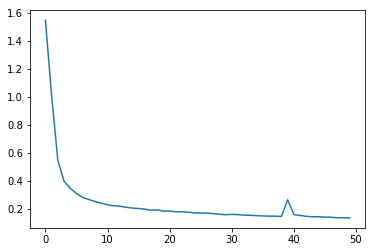

In [99]:
trainIters(True, encoder, attndecoder, 5000, print_every=500, learning_rate=0.0005)

## Evaluation

In [100]:
def evaluate(attention, encoder, decoder):  
    test_batch = get_batch(input_test, labels_test, batch_size*8)

    input_variable = Variable(torch.LongTensor((test_batch[0].astype('int64'))), volatile=True).cuda()
    target_variable = Variable(torch.LongTensor(test_batch[1].astype('int64')), volatile=True).cuda()

    _, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size*8).cuda()

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size*8), volatile=True).cuda()
    
    decoder_hidden = encoder_hidden
    decoded_words = []
    for di in range(target_length):
        if attention:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
        else:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)                
        _, indices = torch.max(decoder_output, 1)
        decoded_words.append(indices)
        decoder_input = indices
    preds = []
    for x in decoded_words:
        preds.append(x.cpu().data.numpy())
    preds = np.array(preds).T
    print ('Accuracy', np.mean([all(real==p) for real, p in zip(test_batch[1], preds)])*100,'%')
    
    print ('  Phonemes_________________________________predictions____________label')
    for index in range(32):
        phoneme = '-'.join([phonemes[p] for p in test_batch[0][index]])
        prediction = [letters[l] for l in preds[index]]
        real = [letters[l] for l in test_batch[1][index]]
        print ('  ',phoneme.strip('-_').ljust(40), ''.join(prediction).strip('_').ljust(20), 
               ''.join(real).strip('_'))

In [108]:
evaluate(True, encoder, attndecoder)

Accuracy 46.38671875 %
  Phonemes_________________________________predictions____________label
   R-AA1-K-ER0-Z                            rockers              rockers
   M-EY1-D-AH0-L                            maidle               maidel
   HH-AE1-M-ER0-S-L-IY0                     hammersly            hammersley
   S-AA0-M-AO1-R-AH0                        samora               samora
   B-IH0-D-EH1-V-AH0-L                      bedevile             bedevil
   AH0-G-R-IY1-V-D                          aggrieved            aggrieved
   K-AE1-R-AH0-T                            carrott              carrot
   S-N-AE1-P-D-R-AE2-G-AH0-N                snapdragen           snapdragon
   K-AA1-M-AH0-S-T                          commust              calmest
   W-AO1-S-AH0-L                            wasle                wassell
   CH-AY1-K-AH0                             chika                czajka
   AA2-K-W-AH0-M-ER0-IY1-N                  acqumarine           aquamarine
   T-AH1-S-AH0-L      

## Serialization

In [ ]:
torch.save(encoder, 'models/encoder.dat')
torch.save(decoder, 'models/decoder.dat')

In [ ]:
encoder = torch.load('models/encoder.dat')
decoder = torch.load('models/decoder.dat')

## References 
<ol>
<li>[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)</li>
<li>[Spro's seq2seq Pytorch Tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb)</li> 
<li>[fast.ai MOOC](http://www.fast.ai/)</li>
<li>[AuCson's implementation](https://github.com/AuCson/PyTorch-Batch-Attention-Seq2seq/blob/master/attentionRNN.py)</li>
</ol>
